In [1]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [2]:
#nbi:hide_in
import torch
import data_loader.data_loaders as module_data
from data_loader.data_loaders import NormDataLoader
import model.model as module_arch
from utils import get_instance

import math
import librosa
from IPython.display import display, Audio
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

model_path = 'saved/gmvae-synth/spec-norm-ss_1.0-latent_16-pow_0-lvl_0-pc_1-pd_1-val_lower_bound/model_best.pth'
sr = 22050
n_fft = 2048
n_mel = 256
hop_length = 256
fmin = 27
fmax = 11000

def griffinlim(spectrogram, n_iter = 100, window = 'hann', n_fft = 2048, hop_length = -1, verbose = False):
    if hop_length == -1:
        hop_length = n_fft // 4

    angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

    t = tqdm(range(n_iter), ncols=100, mininterval=2.0, disable=not verbose)
    for i in t:
        full = np.abs(spectrogram).astype(np.complex) * angles
        inverse = librosa.istft(full, hop_length = hop_length, window = window)
        rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
        angles = np.exp(1j * np.angle(rebuilt))

        if verbose:
            diff = np.abs(spectrogram) - np.abs(rebuilt)
            t.set_postfix(loss=np.linalg.norm(diff, 'fro'))

    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)

    return inverse


def denormalize(S, d_min, d_max):
    S = ((S + 1) / (2)) * (d_max - d_min) + d_min
    S = np.exp(S)
    return S

dl_norm = NormDataLoader(data_dir="data/spec",
                         batch_size=512, validation_split=0.1, shuffle=True, num_workers=0)

d_max = -math.inf
d_min = math.inf
for i, (data, target, idx) in enumerate(dl_norm):
    if data.max().item() > d_max:
        d_max = data.max().item()    
    if data.min().item() < d_min:
        d_min = data.min().item()
        
mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mel, fmin=fmin, fmax=fmax)

resume = torch.load(model_path)
config = resume['config']
n_class = config['arch']['args']['n_class']
latent_dim = config['arch']['args']['latent_dim']
batch_size = config['data_loader']['args']['batch_size']
model = get_instance(module_arch, 'arch', config)
# model.summary()
model.load_state_dict(resume['state_dict'])
model.eval()
model.is_featExtract = False
data_loader = get_instance(module_data, 'data_loader', config)
valid_data_loader = data_loader.split_validation()

pitch_map = data_loader.dataset.pitch_map
pitchclass_map = data_loader.dataset.pitchclass_map
inv_pitch_map = {v: k for k, v in pitch_map.items()}
inv_pitchclass_map = {v: k for k, v in pitchclass_map.items()}
desired_ins_key = ['Ehn', 'Fhn', 'Trtb', 'Trop', 'Pno', 'Vn', 'Vc', 'Sax', 'Bn', 'Clr', 'Fl', 'Ob']
ins_map = {i: n for n, i in enumerate(desired_ins_key)}
inv_ins_map = {v: k for k, v in ins_map.items()}

def control_syn(octave, pitchclass, instrument):
    plt.close()
    pitch = inv_pitchclass_map[pitchclass] + str(octave)
    print(pitch, inv_ins_map[instrument])
    t_id, p_id = instrument, pitch_map[pitch]
    t_id, p_id = torch.tensor(t_id), torch.tensor(p_id)
    mu_t = model.mu_lookup(t_id).data.unsqueeze(0)
    logvar_t = model.logvar_lookup(t_id).data.unsqueeze(0)
    mu_p = model.pitch_mu_lookup(p_id).unsqueeze(0)
    logvar_p = model.pitch_logvar_lookup(p_id).unsqueeze(0)
    z_t = model._infer_latent(mu_t, logvar_t, weight=1)[2]
    z_p = model._infer_latent(mu_p, logvar_p, weight=1)[2]
    S = model._decode(torch.cat([z_t, z_p], dim=1)).data.numpy().squeeze(0)
    S = denormalize(S, d_min, d_max)
    plt.imshow(librosa.power_to_db(S), aspect='auto', origin='lower')
    S_stft = np.dot(mel_filter.T, S)
    x = griffinlim(S_stft, n_iter=50, n_fft=n_fft, hop_length=hop_length)
    display(Audio(x, rate=sr))

/home/ycy/anaconda3/envs/gmvae-synth/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/ycy/anaconda3/envs/gmvae-synth/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


<h1><center>Learning Disentangled Representations of <br>
    Timbre and Pitch for Musical Instrument Sounds Using <br>
    Gaussian Mixture Variational Autoencoders</center></h1>
<h2><center>Supplementary Audio Files and <a href=https://github.com/yjlolo/vae-audio>Code</a></center></h2>
<h3><center>Yin-Jyun Luo$^{1}$, Kat Agres$^{2,3}$, Dorien Herremans$^{1,2}$</center></h3>
<center>$^{1}$Singapore University of Technology and Design</center>
<center>$^{2}$Institute of High Performance Computing, A*STAR, Singapore</center>
<center>$^{3}$Yong Siew Toh Conservatory of Music, National University of Singapore</center>
<center><small>$\tt yinjyun\_luo@mymail.sutd.edu.sg, kat\_agres@ihpc.a-star.edu.sg, dorien\_herremans@sutd.edu.sg$</small></center>

<h3>Controllable Synthesis of Instrument Sounds Given Pitch and Instrument</h3><br>
In this section, we complement the paper with the following synthesized Mel-spectrograms and the corresponding audio files.<br>

We generate the Mel-spectrograms as described in the paper, and use Griffin-Lim to synthesize the waveforms. Note that we do not focus on good audio quality in this paper, and the inferior quality is mainly due to the algorithm used to synthesize the waveforms (as the original Mel-spectrograms and the generated ones result in the similar audio quality). We will address this, in the future work, by using advanced auto-regressive networks such as wavenets for audio synthesis.

Firstly, we present the audio that is synthesized using the original Mel-spectrogram. Specifically, we convert a sample to Mel-spectrogram, and resynthesize back to audio using Griffin-Lim. This is to give a reference of the audio quality obtained by Griffin-Lim in this work. 

In [3]:
print(color.BOLD + "French horn" + color.END)
x, _ = librosa.core.load('data/sample/Hn-ord-C4-mf.wav', duration=0.5)
print("The original audio waveform")
display(Audio(x, rate=sr))
S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
S_stft = np.dot(mel_filter.T, S)
x_ = griffinlim(S_stft, n_iter=50, hop_length=hop_length, n_fft=n_fft)
print("The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim")
display(Audio(x_, rate=sr))

print(color.BOLD + "Piano" + color.END)
x, _ = librosa.core.load('data/sample/Pno-ord-C4-mf.wav', duration=0.5)
print("The original audio waveform")
display(Audio(x, rate=sr))
S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
S_stft = np.dot(mel_filter.T, S)
x_ = griffinlim(S_stft, n_iter=50, hop_length=hop_length, n_fft=n_fft)
print("The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim")
display(Audio(x_, rate=sr))

print(color.BOLD + "Cello" + color.END)
x, _ = librosa.core.load('data/sample/Vc-ord-C4-mf.wav', duration=0.5)
print("The original audio waveform")
display(Audio(x, rate=sr))
S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
S_stft = np.dot(mel_filter.T, S)
x_ = griffinlim(S_stft, n_iter=50, hop_length=hop_length, n_fft=n_fft)
print("The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim")
display(Audio(x_, rate=sr))

print(color.BOLD + "Basson" + color.END)
x, _ = librosa.core.load('data/sample/fagf-ordinario-C4-f.aif', duration=0.5)
print("The original audio waveform")
display(Audio(x, rate=sr))
S = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mel, fmin=fmin, fmax=fmax)
S_stft = np.dot(mel_filter.T, S)
x_ = griffinlim(S_stft, n_iter=50, hop_length=hop_length, n_fft=n_fft)
print("The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim")
display(Audio(x_, rate=sr))

French horn
The original audio waveform


The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim


Piano
The original audio waveform


The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim


Cello
The original audio waveform


The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim


Basson
The original audio waveform


The resynthesized audio waveform from the Mel-spectrogram using Grin-Lim


Now we demonstrate the controllable sound synthesis. As described in the paper Section 4.3, we specify the target pitch $\mathbf{y_m}$ and instrument $\mathbf{y_k}$, and sample the pitch code $\mathbf{z}_p$ and timbre code $\mathbf{z}_t$ from the conditional distribution $p(\mathbf{z}_p | \mathbf{y_m})$ and $p(\mathbf{z}_t | \mathbf{y_k})$, respectively, where $p(\mathbf{z}_{p} | \mathbf{y}_{p}) = \mathcal{N}(\mathbf{\mu}_{\mathbf{y}_{p}}, \textrm{diag}(\mathbf{\sigma}_{\mathbf{y}_{p}}))$ and $p(\mathbf{z}_{t} | \mathbf{y}_{t}) = \mathcal{N}(\mathbf{\mu}_{\mathbf{y}_{t}}, \textrm{diag}(\mathbf{\sigma}_{\mathbf{y}_{t}}))$. In the following demonstration, we specify the same pitches for all instruments, play the audio and display the corresponding Mel-spectrograms.

z_rho 0.010483996942639351
pitch rho -0.00535905547440052
English horn


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.025662820786237717
pitch rho -0.00535905547440052
French horn


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.0008488202001899481
pitch rho -0.00535905547440052
Tenor Trombone


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho -0.0015914349351078272
pitch rho -0.00535905547440052
Trompet


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho -0.012049826793372631
pitch rho -0.00535905547440052
Piano


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.0510697141289711
pitch rho -0.00535905547440052
Violin


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.04268498718738556
pitch rho -0.00535905547440052
Cello


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.0031022648327052593
pitch rho -0.00535905547440052
Saxophone


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.013757976703345776
pitch rho -0.00535905547440052
Bassoon


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.030385872349143028
pitch rho -0.00535905547440052
Clarinet


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho -0.04692649468779564
pitch rho -0.00535905547440052
Flute


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


z_rho 0.0005137908738106489
pitch rho -0.00535905547440052
Oboe


pitch rho -0.0016817259602248669


pitch rho -0.0048317620530724525


pitch rho -0.001077142427675426


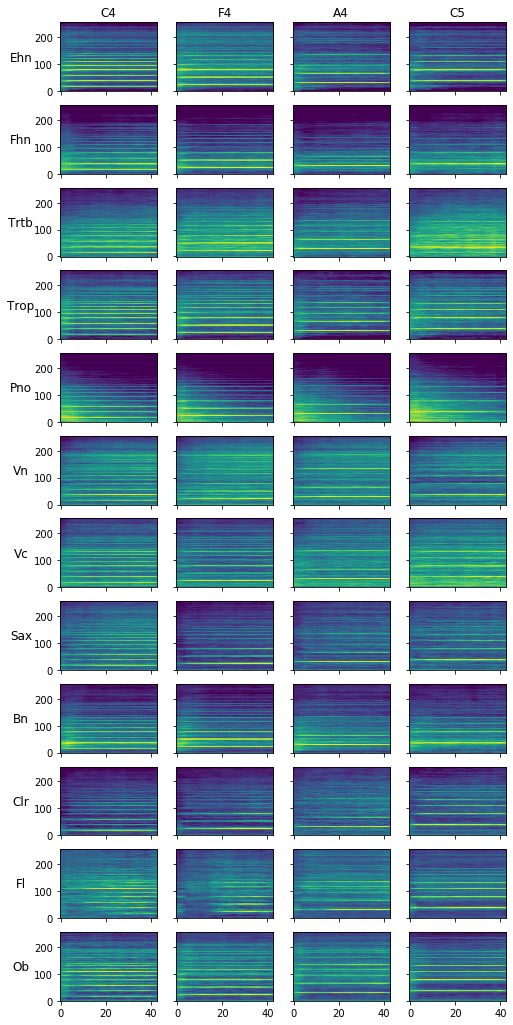

In [7]:
#nbi:hide_in
scale = ['C4', 'F4', 'A4', 'C5']
ins_code_to_name = {'Ehn': 'English horn', 'Fhn': 'French horn', 'Trtb': 'Tenor Trombone', 'Trop': 'Trompet', 'Pno': 'Piano', 
                    'Vn': 'Violin', 'Vc': 'Cello', 'Sax': 'Saxophone', 'Bn': 'Bassoon', 'Clr': 'Clarinet',
                    'Fl': 'Flute', 'Ob': 'Oboe'}
scale_ind = [pitch_map[i] for i in scale]
desired = [ins_map[i] for i in desired_ins_key]
weight = 0  # sampling from the mode - the means of each mixture component
fig, ax = plt.subplots(len(desired), len(scale), figsize=(len(scale) * 2, len(desired) * 1.5), sharex=True, sharey=True)
model.is_featExtract = False
for i, n in enumerate(desired):
    n = torch.tensor(n)
    mu_k = model.mu_lookup(n).data.unsqueeze(0)
    logs_k = model.logs_lookup(n).data
    rho_k = model.rho_lookup(n).data.tanh() * 0.99999
    
    print("z_rho", rho_k.item())
    if i == 0:
        mu_prior = mu_k
        logs_prior = logs_k
        rho_prior = rho_k
    else:
        mu_prior = torch.cat([mu_prior, mu_k], dim=0)
        logs_prior = torch.cat([logs_prior, logs_k], dim=0)
        rho_prior = torch.cat([rho_prior, rho_k], dim=0)

    z_t = model._infer_latent(mu_k, logs_k, rho_k, weight=weight)[-1]  # sample from prior

    for m, (pitch_name, pitch_ind) in enumerate(zip(scale, torch.tensor(scale_ind))):
        mu_m = model.pitch_mu_lookup(pitch_ind).unsqueeze(0)
        logs_m = model.pitch_logs_lookup(pitch_ind)
        rho_m = model.pitch_rho_lookup(pitch_ind).tanh() * 0.99999
        print("pitch rho", rho_m.item())
        z_p = model._infer_latent(mu_m, logs_m, rho_m, weight=weight)[-1]
        S = model._decode(torch.cat([z_t, z_p], dim=1)).data.numpy().squeeze(0)
        S = denormalize(S, d_min, d_max)
        ax[i][m].imshow(librosa.power_to_db(S), aspect='auto', origin='lower')
        S_stft = np.dot(mel_filter.T, S)
        x = griffinlim(S_stft, n_iter=50, n_fft=n_fft, hop_length=hop_length)

        if i == 0:
            ax[i][m].set_title(pitch_name)
        if m == 0:
            print(color.BOLD + ins_code_to_name[inv_ins_map[n.item()]] + color.END)#, scale)
            ax[i][m].set_ylabel(inv_ins_map[n.item()], rotation=0, size='large')
            ax[i][m].yaxis.set_label_coords(-0.4, 0.4)
        display(Audio(x, rate=sr))
plt.show()

<h3>Many-to-Many timbre transfer</h3><br>
In this section, we demonstrate the model's applicability in timbre transfer.

As described in Section 4.4 in the paper, we first infer $\mathbf{z}_p$ and $\mathbf{z}_t$ of the source input, and modify $\mathbf{z}_t$ (denoted as $\mathbf{z}_{source}$) by:
$$\mathbf{z}_{transfer} = \mathbf{z}_{source} + \alpha\mathbf{\mu}_{source \rightarrow target},$$<br>
where $\mathbf{\mu}_{source \rightarrow target} = \mathbf{\mu}_{target} - \mathbf{\mu}_{source}$, and $\alpha \in [0, 1]$. We then synthesize the spectrogram by passing $[\mathbf{z}_p, \mathbf{z}_{transfer}]$ to the decoder. See Fig. 4 for an illsutration of transferring French horn to piano. 

Note that, in practice, we do not need labels of source instrument and pitch for timbre transfer, as the two variables are automatically inferred by $q(\mathbf{z}_p | \mathbf{X})$ and $q(\mathbf{z}_t | \mathbf{X})$, respectively. $q(\mathbf{y}_{t} | \mathbf{X})$ infers the mixture component (source instrument identity) to which $\mathbf{X}$ belongs, and $\mathbf{\mu}_{source \rightarrow target}$ is then obtained by subtracting mean of the mixture component of the target to the that of the source.

In [8]:
#nbi:hide_in
import pandas as pd
pitchclass_map = data_loader.dataset.pitchclass_map
dyn_map = data_loader.dataset.dynamic_map
inv_pitchclass_map = {v: k for k, v in pitchclass_map.items()}
inv_dyn_map = {v: k for k, v in dyn_map.items()}
def call_inv_dyn(x):
    return inv_dyn_map[x]

def call_inv_pitchclass(x):
    return inv_pitchclass_map[x]

def call_inv_pitch(x):
    return inv_pitch_map[x]

def call_inv_ins(x):
    return inv_ins_map[x]

def get_octave(x):
    return x[-1]

def get_octave_range(x):
    if int(x) <= 4:
        return 'low'
    else:
        return 'high'
torch.manual_seed(123)
with torch.no_grad():
    # for i, (data, target, data_ind) in enumerate(data_loader):
    for i, (data, target, data_ind) in enumerate(valid_data_loader):
        y_ins, y_pitch_class, y_pitch, y_dyn = target[0], target[1], target[2], target[3]
        n_band, context_size = data.size(2), data.size(3)
        data = data.view(-1, n_band, 1, context_size).squeeze(2)
        x_predict, mu, logs, rho, z, log_q_y_logit, q_y, ind, pitch_mu, pitch_logs, pitch_rho, pitch_z, pitch_logit\
            = model(data)

        if i == 0:
            idx_all = data_ind
            assign = ind
            d_all = data
            z_all = z
            logs_all = logs
            rho_all = rho
            ins_gt = y_ins
            pitch_gt = y_pitch
            pitchclass_gt = y_pitch_class
            dyn_gt = y_dyn
            x_predict_all = x_predict
            if model.is_pitch_condition:
                pitch_z_all = pitch_z
        else:
            idx_all = torch.cat([idx_all, data_ind])
            assign = torch.cat([assign, ind])
            d_all = torch.cat([d_all, data], dim=0)
            z_all = torch.cat([z_all, z], dim=0)
            logs_all = torch.cat([logs_all, logs], dim=0)
            rho_all = torch.cat([rho_all, rho], dim=0)
            ins_gt = torch.cat([ins_gt, y_ins])
            pitch_gt = torch.cat([pitch_gt, y_pitch])
            pitchclass_gt = torch.cat([pitchclass_gt, y_pitch_class])
            dyn_gt = torch.cat([dyn_gt, y_dyn])
            x_predict_all = torch.cat([x_predict_all, x_predict], dim=0)
            if model.is_pitch_condition:
                pitch_z_all = torch.cat([pitch_z_all, pitch_z], dim=0)
                
d = {
    'ins': ins_gt.data.numpy(),
    'pitch': pitch_gt.data.numpy(),
    'pitchclass': pitchclass_gt.data.numpy(),
    'dyn': dyn_gt.data.numpy(),
    'assign': assign.data.numpy()
}
df = pd.DataFrame(d)
df['dyn_inv'] = np.vectorize(call_inv_dyn)(df['dyn'])
df['pitchclass_inv'] = np.vectorize(call_inv_pitchclass)(df['pitchclass'])
df['pitch_inv'] = np.vectorize(call_inv_pitch)(df['pitch'])
df['ins_inv'] = np.vectorize(call_inv_ins)(df['ins'])
df['octave'] = np.vectorize(get_octave)(df['pitch_inv'])
df['octave_range'] = np.vectorize(get_octave_range)(df['octave'])
df.head()
def recognize_family(x):
    if x in [0, 1, 2, 3]:
        y = 'brass'
    elif x in [5, 6]:
        y = 'string'
    elif x == 4:
        y = 'piano'
    else:
        y = 'wind'
    return y
df['family'] = np.vectorize(recognize_family)(df['ins'])
df.groupby(['family', 'ins_inv']).size()
# pins.groupby(['instrument', 'pitch']).size().unstack(fill_value=0)

#nbi:hide_in
source_ins = 'Pno'
target_ins = 'Vc'
desired_octave = 4

def timbre_transfer(source_ins, target_ins, desired_pitches=None, n_sample=None):
    mu_target = mu_prior[ins_map[target_ins]]
    mu_source = mu_prior[ins_map[source_ins]]
    mu_s2t = (mu_target - mu_source).unsqueeze(0)
    source_idx = np.where((df['ins_inv'] == source_ins))[0]

    filter_pitch, filter_dyn, filter_int = np.array(df['pitch_inv'][source_idx]), np.array(df['dyn_inv'][source_idx]), np.array(df['ins_inv'][source_idx])

    alpha = [0.25, 0.5, 0.75, 1.0]
    if not n_sample:
        n_sample = 2
    else:
        n_sample = len(source_idx)
    n_col = len(alpha) + 1
    np.random.seed(111)
    sample_idx = np.random.choice(source_idx, n_sample, replace=False)
    if desired_pitches:
        sample_idx = [i for i in sample_idx if df['pitch_inv'][i] in desired_pitches]
    n_row = len(sample_idx) 
    fig, ax = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2), sharey=True, sharex=True)

    for n, i in enumerate(sample_idx):
        #target_ins_idx = np.where((df['ins_inv'] == target_ins) & 
        #                          (df['pitch_inv'] == df['pitch_inv'][i]))[0]
        zp_source = pitch_z_all[i].unsqueeze(0)
        zt_source = z_all[i]
        s_source = x_predict_all[i].data.numpy()
        s_source = denormalize(s_source, d_min, d_max)
        ax[n][0].imshow(librosa.power_to_db(s_source), aspect='auto', origin='lower')
        if n == 0:
            ax[n][0].set_title(r'$\alpha = 0$', fontsize=15)
        ax[n][0].set_ylabel('%s %s'% (source_ins, df['pitch_inv'][i]), rotation=360, fontsize=15)
        ax[n][0].yaxis.set_label_coords(-0.5, 0.5)
        x_source = griffinlim(np.dot(mel_filter.T, s_source), n_iter=50, n_fft=2048, hop_length=hop_length)
        print(df['pitch_inv'][i], df['dyn_inv'][i], df['ins_inv'][i])
        display(Audio(x_source, rate=22050))
        ax[n][0].imshow(librosa.power_to_db(s_source), aspect='auto', origin='lower')
        for k, a in enumerate(alpha):
            z_s2t = zt_source + a * mu_s2t
            s_transfer = model._decode(torch.cat([z_s2t, zp_source], dim=1)).squeeze(0).data.numpy()
            s_transfer = denormalize(s_transfer, d_min, d_max)

            ax[n][k + 1].imshow(librosa.power_to_db(s_transfer), aspect='auto', origin='lower')
            if n == 0:
                ax[n][k + 1].set_title(r'$\alpha = %.2f$' % a, fontsize=15)

            if k == len(alpha)-1:
                ax2 = ax[n][k + 1].twinx()
                ax2.set_ylabel(target_ins, rotation=360, fontsize=15)
                ax2.yaxis.set_label_coords(1.33, 0.6)
                ax2.set_yticks([])
            x_transfer = griffinlim(np.dot(mel_filter.T, s_transfer), n_iter=50, n_fft=2048, hop_length=hop_length)
            display(Audio(x_transfer, rate=22050))
    plt.tight_layout()

Following Fig. 5 in the paper, we demonstrate $\texttt{Fhn} \rightarrow \texttt{Pno}$, $\texttt{Pno} \rightarrow \texttt{Vc}$, $\texttt{Vc} \rightarrow \texttt{Bn}$, and $\texttt{Bn} \rightarrow \texttt{Fhn}$.<br>
The source instrument is gradually changed to the target instrument, by $\alpha=\{0, 0.25, 0.5, 0.75, 1.0\}$.

<h4>French horn to piano</h4>

C2 mf Fhn


F#2 pp Fhn


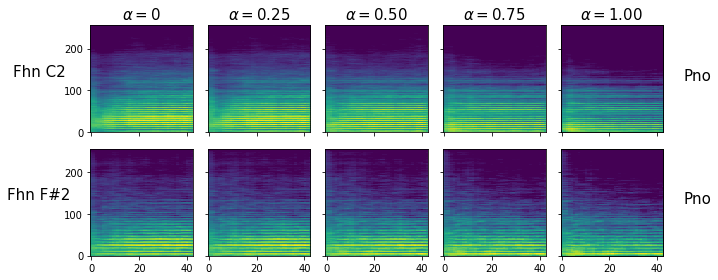

In [9]:
timbre_transfer('Fhn', 'Pno')

<h4>Piano to cello</h4><br>
Notice that the model is able to generalize to the pitch $\texttt{G6}$ which is not within the range of the cello.

G6 pp Pno


D3 pp Pno


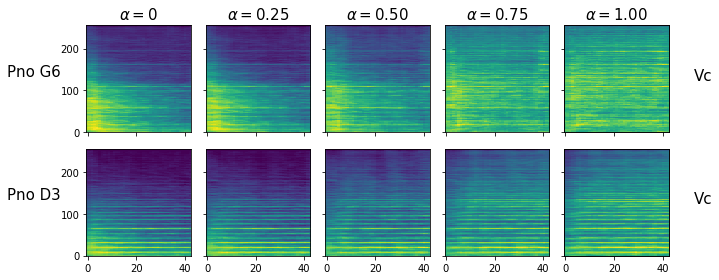

In [10]:
timbre_transfer('Pno', 'Vc', desired_pitches=['G6', 'D3'], n_sample=2)

<h4>Cello to Bassoon</h4><br>

F3 pp Vc


D#4 pp Vc


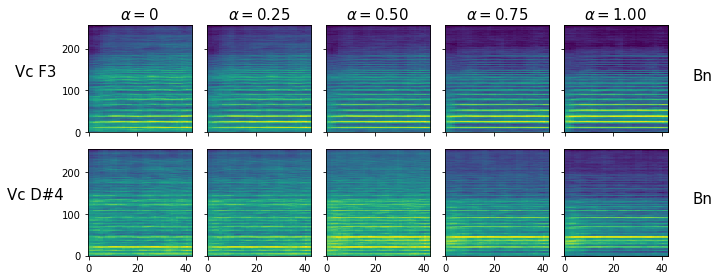

In [11]:
timbre_transfer('Vc', 'Bn')

<h4>Bassoon to French horn</h4><br>

D#4 pp Bn


C5 pp Bn


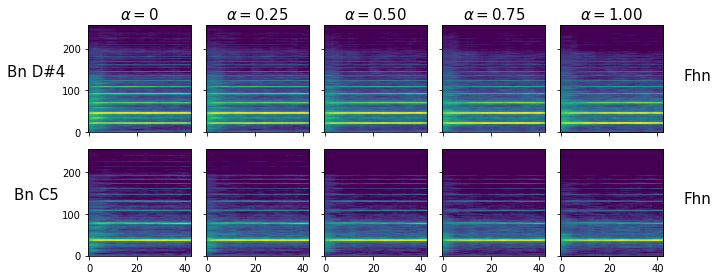

In [12]:
timbre_transfer('Bn', 'Fhn')

<h3>Disentangling the spectral centroid</h3><br>
In this section, we present the effect of latent traverse along the $13$th dimension of $\mathbf{z}_t$, which is discussed in Section 4.5 of the paper.

Ehn-B3-mf


Trop-D5-mf


Pno-C#6-mf


Vn-A4-mf


Bn-A3-mf


Ob-F6-mf


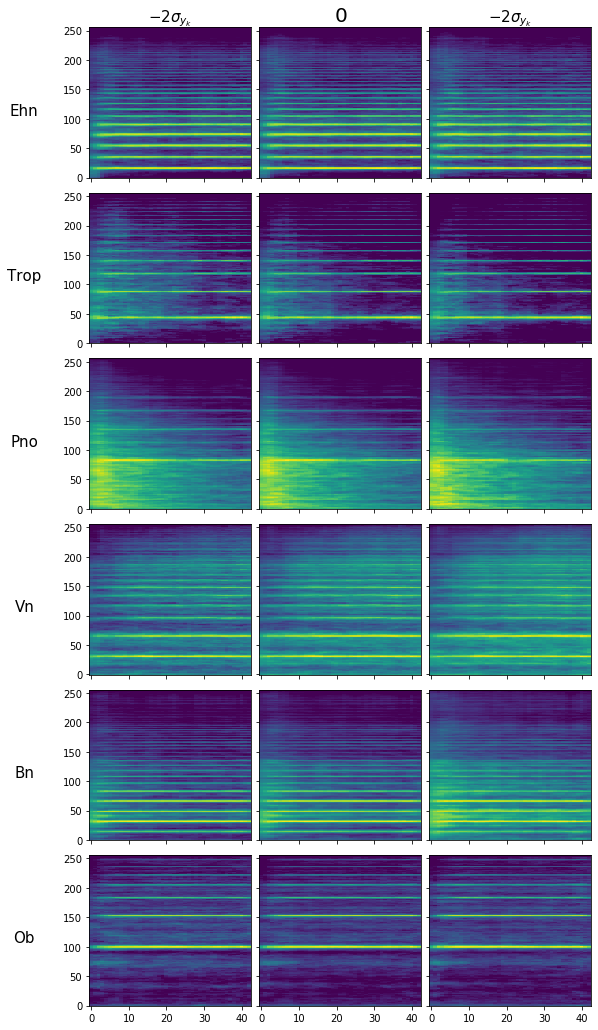

In [13]:
target_dim = -1
w = 2

desired_inst = ['Ehn', 'Trop', 'Pno', 'Vn', 'Bn', 'Ob']
fig, ax = plt.subplots(len(desired_inst), 3, figsize=(3 * 3, len(desired_inst)* 3), gridspec_kw = {'wspace':0.05, 'hspace':0.1},
                       sharex=True, sharey=True)
n = 0
for k, v in inv_ins_map.items():
    if v in desired_inst:
        idx = np.where((df['ins_inv'] == v) & (df['dyn_inv'] == 'mf'))[0]
        #np.random.seed(2)
        np.random.seed(123)
        idx_sample = np.random.choice(idx, 1)
        z_t = z_all[idx_sample]
        z_p = pitch_z_all[idx_sample]
        std_ins = logs_prior[k].exp().sqrt()
        trav = torch.zeros(1, latent_dim)
        trav[:, target_dim] = std_ins#[target_dim]
        pos_trav = trav * w
        neg_trav = trav * (-w)
        z_t_mid = z_t
        z_t_pos = z_t + pos_trav
        z_t_neg = z_t + neg_trav

        S_mid = model._decode(torch.cat([z_t_mid, z_p], dim=1)).squeeze(0).data.numpy()
        S_pos = model._decode(torch.cat([z_t_pos, z_p], dim=1)).squeeze(0).data.numpy()
        S_neg = model._decode(torch.cat([z_t_neg, z_p], dim=1)).squeeze(0).data.numpy()
        S_mid = denormalize(S_mid, d_min, d_max)
        S_pos = denormalize(S_pos, d_min, d_max)
        S_neg = denormalize(S_neg, d_min, d_max)


        ax[n][0].imshow(librosa.power_to_db(S_neg), aspect='auto', origin='lower')
        ax[n][1].imshow(librosa.power_to_db(S_mid), aspect='auto', origin='lower')
        ax[n][2].imshow(librosa.power_to_db(S_pos), aspect='auto', origin='lower')
        tit = '-'.join([df.iloc[idx_sample]['ins_inv'].values[0], 
                        df.iloc[idx_sample]['pitch_inv'].values[0], 
                        df.iloc[idx_sample]['dyn_inv'].values[0]])
        if n == 0:
            ax[n][0].set_title(r'$-2\sigma_{y_{k}}$', fontsize=15)
            ax[n][1].set_title(r'$0$', fontsize=20)
            ax[n][2].set_title(r'$-2\sigma_{y_{k}}$', fontsize=15)

        ax[n][0].set_ylabel(v, rotation=360, fontsize=15)
        ax[n][0].yaxis.set_label_coords(-0.4, 0.4)
        S_mid = np.dot(mel_filter.T, S_mid)
        S_pos = np.dot(mel_filter.T, S_pos)
        S_neg = np.dot(mel_filter.T, S_neg)
        x_mid = griffinlim(S_mid, n_iter=50, n_fft=n_fft, hop_length=hop_length)
        x_pos = griffinlim(S_pos, n_iter=50, n_fft=n_fft, hop_length=hop_length)
        x_neg = griffinlim(S_neg, n_iter=50, n_fft=n_fft, hop_length=hop_length)
        print(tit)
        display(Audio(x_neg, rate=sr))
        display(Audio(x_mid, rate=sr))
        display(Audio(x_pos, rate=sr))
        n+=1


In [18]:
print(model.rho_lookup.weight.squeeze().tanh() * 0.99999)
print(torch.sort(torch.abs(model.pitch_rho_lookup.weight.squeeze().tanh() * 0.99999)))

tensor([ 0.0105,  0.0257,  0.0008, -0.0016, -0.0120,  0.0511,  0.0427,  0.0031,
         0.0138,  0.0304, -0.0469,  0.0005], grad_fn=<MulBackward0>)
torch.return_types.sort(
values=tensor([4.6742e-05, 4.8030e-05, 8.3027e-05, 8.6009e-05, 9.7249e-05, 1.4037e-04,
        1.9108e-04, 2.7023e-04, 3.1441e-04, 3.5047e-04, 4.7751e-04, 5.1820e-04,
        5.3865e-04, 6.1212e-04, 6.1784e-04, 8.0626e-04, 8.1517e-04, 8.8949e-04,
        9.1854e-04, 9.3182e-04, 9.6532e-04, 1.0771e-03, 1.1284e-03, 1.1508e-03,
        1.2581e-03, 1.4397e-03, 1.4982e-03, 1.5034e-03, 1.6691e-03, 1.6817e-03,
        1.7421e-03, 1.8123e-03, 1.8618e-03, 1.9045e-03, 1.9051e-03, 1.9988e-03,
        2.0491e-03, 2.1416e-03, 2.2386e-03, 2.2609e-03, 2.2783e-03, 2.3516e-03,
        2.3550e-03, 2.3948e-03, 2.6884e-03, 2.8331e-03, 2.8472e-03, 2.9205e-03,
        3.0434e-03, 3.0709e-03, 3.1500e-03, 3.2617e-03, 3.2627e-03, 3.5407e-03,
        3.5567e-03, 3.7246e-03, 3.9487e-03, 4.0650e-03, 4.3038e-03, 4.3679e-03,
        4.5016e-03,